# Classification model + insights.

In dit notebook wordt het binaire classificatie model getraind en worden de nodige insights uit het model gehaald.

In [1]:
from sklearn.linear_model import LogisticRegression 

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split 

from sklearn import metrics 

import pandas as pd 

import numpy as np 

import matplotlib.pyplot as plt 

from sklearn.metrics import roc_auc_score

from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

import seaborn as sns 

import json

from functools import partial

import os

from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
#import shap #werkt niet in pytthon 3.11
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import re
from collections import Counter

from sklearn.preprocessing import LabelEncoder
import psycopg2
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import shap
import scipy.sparse

from hyperopt import fmin, tpe, hp, SparkTrials, STATUS_OK, Trials
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from hyperopt import SparkTrials
import pyspark
import mlflow
from pyspark.sql import SparkSession

import pickle

In [1]:
# Import the Data from the database istade of csv
conn = psycopg2.connect(database="mimic4", user='postgres', password='b#!TyE4cP5^r@hM@Fs28', host='31.220.74.113', port='5432')



In [ ]:
#

In [3]:
%%time
data = pd.read_csv("DES.csv",engine="pyarrow") 
df = pd.DataFrame(data)

CPU times: total: 625 ms
Wall time: 504 ms


In [4]:
# Create the binary target variable based on length_of_stay_days
LOS_THRESHOLD = 3
df['target'] = np.where(df['length_of_stay_days'] > LOS_THRESHOLD, 1, 0)
print(df['target'].value_counts() , 'before resample')

1    141316
0     88105
Name: target, dtype: int64 before resample


In [5]:
df

,,patient_id,geslacht,geboortedatum,opname_nummer,zkh_opn_start,herkomst,marital_status,race,diagnose,icd_version,start_operatie,endtime,duur_ok_minutes,length_of_stay_days,department,time_to_surgery_minutes,target
0,0,10000032,F,2180-09-09,22595853,2180-05-06 22:23:00,Other,WIDOWED,WHITE,07070,9,2180-05-06 19:17:00,2180-05-07 17:21:27,1324.450000,0.786111,MED,-186.0,0
1,1,10000032,F,2180-09-09,22841357,2180-06-26 18:27:00,Medicaid,WIDOWED,WHITE,07071,9,2180-06-26 15:54:00,2180-06-27 18:49:12,1615.200000,1.015278,MED,-153.0,0
2,2,10000032,F,2180-09-09,25742920,2180-08-05 23:44:00,Medicaid,WIDOWED,WHITE,07054,9,2180-08-05 20:58:00,2180-08-07 17:50:44,2692.733333,1.754167,MED,-166.0,0
3,3,10000068,F,None,25022803,2160-03-03 23:16:00,Other,SINGLE,WHITE,30500,9,2160-03-03 21:55:00,2160-03-04 07:33:47,578.783333,0.298611,MED,-81.0,0
4,4,10000117,F,None,27988844,2183-09-18 18:10:00,Other,DIVORCED,WHITE,E7800,10,2183-09-18 08:41:00,2183-09-21 16:30:30,4789.500000,2.930556,ORTHO,-569.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229416,229416,19999828,F,None,25744818,2149-01-08 16:44:00,Other,SINGLE,WHITE,B954,10,2149-01-08 09:11:00,2149-01-18 18:44:40,14973.666667,10.011111,MED,-453.0,1
229417,229417,19999828,F,None,29734428,2147-07-18 16:23:00,Other,SINGLE,WHITE,B9620,10,2147-07-17 17:18:00,2147-08-04 18:12:35,25974.583333,17.074306,SURG,-1385.0,1
229418,229418,19999840,M,2164-09-17,21033226,2164-09-10 13:47:00,Other,WIDOWED,WHITE,2724,9,2164-09-10 11:09:00,2164-09-17 16:35:15,10406.250000,6.996528,MED,-158.0,1
229419,229419,19999840,M,2164-09-17,26071774,2164-07-25 00:27:00,Other,WIDOWED,WHITE,2724,9,2164-07-24 21:16:00,2164-07-28 12:22:30,5226.500000,3.491667,NMED,-191.0,1


In [6]:
df['target'] = df['target'].astype(int)

## Maak X,y split.

hier wordt een functie gedefieneerd die de kolommen in de 'drop_cols' lijst dropt en de overige kolommen splitst tussen de X (voorspellende kolommen) en y (target kolom). Ook dropt deze functie alle rows die een categorie van de target_col bevatten die vijf of minder keer voorkomt.

In [7]:
drop_cols = ['', 'patient_id', 'opname_nummer', 'zkh_opn_start', 'start_operatie', 'endtime', 'geboortedatum','length_of_stay_days','duur_ok_minutes']

def create_Xy(df, drop_cols, target_col):
    # Drop specified columns from df
    df = df.drop(columns=drop_cols)

    # Count the occurrences of each value in target_col
    target_counts = Counter(df[target_col])

    # Get a list of values that occur 5 or less times, stratify will give error otherwise
    remove_values = [k for k, v in target_counts.items() if v <= 5]

    # Remove rows with these values from the DataFrame
    df = df[~df[target_col].isin(remove_values)]

    # Encode the target column as numerical labels
    le = LabelEncoder()
    y = le.fit_transform(df[target_col])

    # Return X and y
    X = df.drop(columns=target_col)
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X, y)
    return X_resampled, y_resampled

X, y = df.pipe(create_Xy, 
                        drop_cols=drop_cols,
                        target_col='target')


In [8]:
categorical_cols = ['herkomst', 'marital_status', 'race', 'icd_version', 'department', 'diagnose','geslacht']

ct = ColumnTransformer([
    ('onehot', OneHotEncoder(handle_unknown = 'ignore', min_frequency=100), categorical_cols)
], remainder='passthrough')
ct

impute = SimpleImputer(strategy='most_frequent')

preprocessing = Pipeline(steps=[
    ('ct', ct),
    ('impute', impute),
])

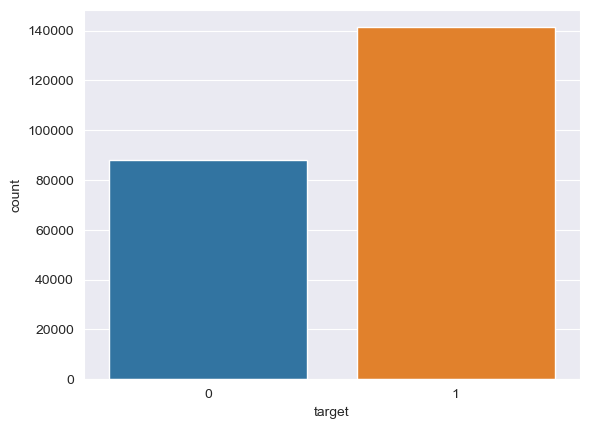

In [9]:
# lets plot plot the distrubion of dataset
sns.countplot(x='target', data=df)
plt.show()


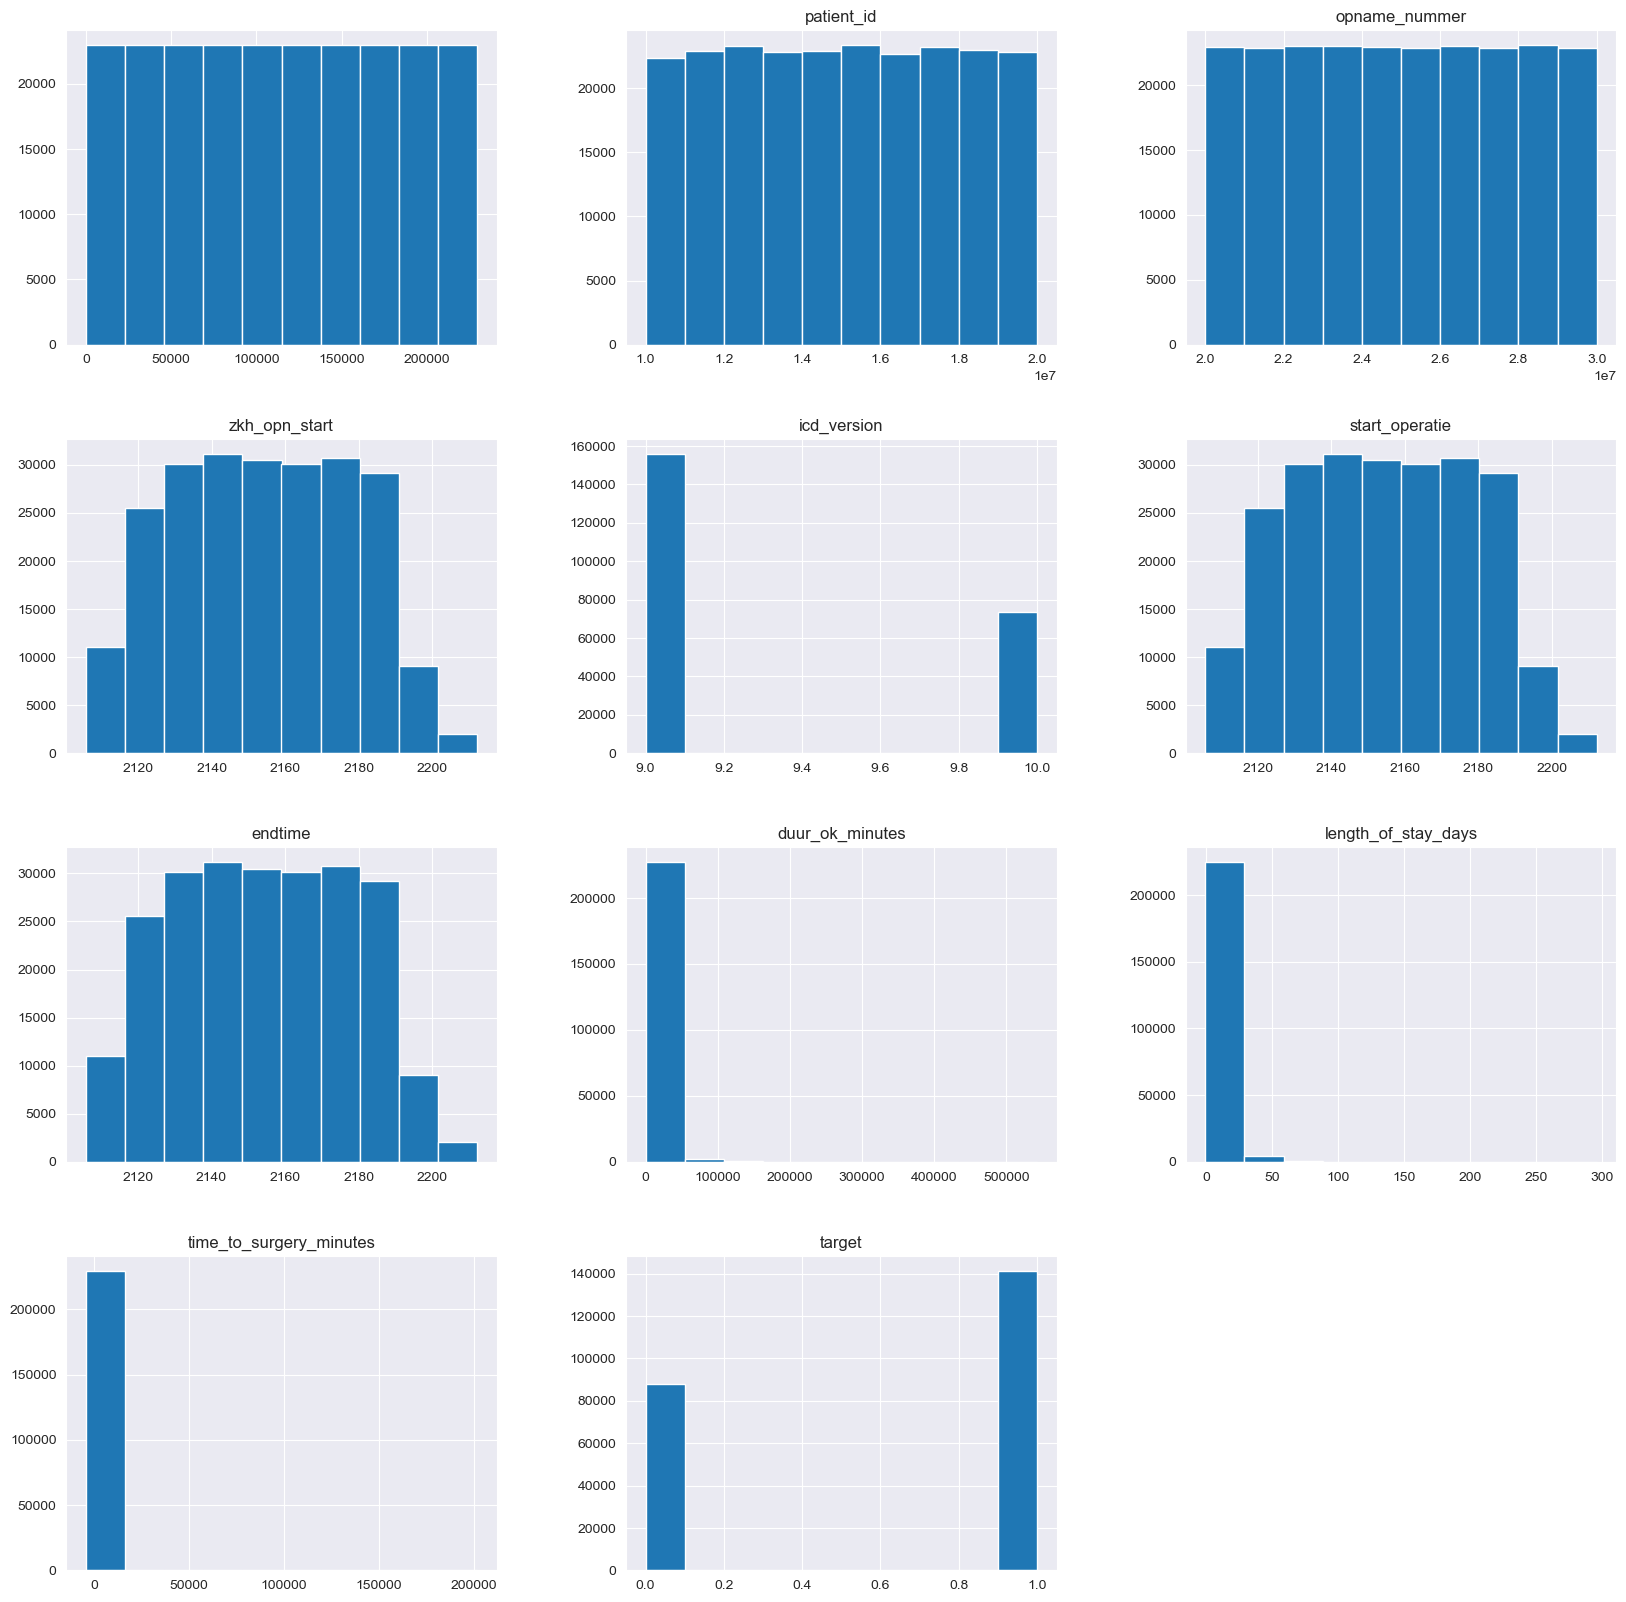

In [10]:
# Lets plot the dataset distubution
df.hist(figsize=(20,20))
plt.show()


In [11]:
# # lets apply log1 transformation on columns length_of_stay_days and duur_ok_minutes
# df['length_of_stay_days'] = np.log1p(df['length_of_stay_days'])
# df['duur_ok_minutes'] = np.log1p(df['duur_ok_minutes'])
#
# df.hist(figsize=(20,20))
# plt.show()

In [12]:
# X = preprocessing.transform(X)
#X = normalize(X, norm='max', axis=1)

In [13]:
 # pd.DataFrame.sparse.from_spmatrix(X)

## Split X,y naar train en test.

Maakt gebruik van de train_test_params om X,y te splitten.

stratify is een techniek die wordt gebruikt bij het opdelen van een dataset in trainings- en testsets om ervoor te zorgen dat de verdeling van de klassen gelijk blijft over de sets. Dit is vooral nuttig in situaties waarbij de verdeling van de klassen onevenwichtig is.

In [14]:
train_test_params = {
    'test_size':0.25, 
    'random_state':42,
    'stratify':y
}

X_train, X_test, y_train, y_test = train_test_split(X, y, **train_test_params)

In [15]:
#X_train.to_csv('X_train.csv', index=False) # needed for others notebook

## Preprocessing pipeline maken.

De code hieronder definieerd de OneHotEncoder en SimpleImputer, daarna worden deze twee functies toegevoegd aan de 'preprocessing' pipeline.

SimpleImputer is een transformer uit scikit-learn die wordt gebruikt om ontbrekende waarden in een dataset op te vullen. Aangezien het meestal geen goed idee is om rijen met ontbrekende gegevens volledig te verwijderen, omdat dit kan leiden tot informatie die verloren gaat. De strategy geeft aan met welke waarde de ontbrekende waardes worden gevuld

De OneHotEncoder is een transformer uit scikit-learn die wordt gebruikt om categorische variabelen om te zetten in numerieke variabelen. Het omzetten van categorische variabelen in numerieke variabelen is belangrijk omdat veel machine learning-modellen alleen numerieke gegevens als invoer accepteren. min_frequency=100 geeft aan dat categorieën die minder dan 1000 keer voorkomen in de dataset niet moeten worden omgezet. In dit geval worden alleen de kolommen die in de 'categorical_cols' lijst staan one-hot-gecodeerd

## Finding the best params

In [16]:
# SparkSession.builder \
# .master('local[*]') \
# .config("spark.driver.memory", "32g") \
# .appName('ML-pipeline') \
# .getOrCreate()

# preprocessing = Pipeline(steps=[
#     ('ct', ct),
#     ('impute', impute),
# ])


In [17]:
# import os
# print(os.environ.get("SPARK_HOME"))
# print(os.path.join(os.environ.get("SPARK_HOME"), './bin/spark-submit.cmd'))
# print(type(X_train))
#
# # lets convert csr_matrix to dataframe
# X_train = pd.DataFrame.sparse.from_spmatrix(X_train)
# X_test = pd.DataFrame.sparse.from_spmatrix(X_test)
#
# # lets converrt form nump ndarray to dataframe
# y_test = pd.DataFrame.sparse.from_spmatrix(y_test)
# y_test = pd.DataFrame.sparse.from_spmatrix(y_test)
#



# y_train = pd.DataFrame.sparse.from_spmatrix(y_train)
# y_test = pd.DataFrame.sparse.from_spmatrix(y_test)


In [18]:
X_train

,geslacht,herkomst,marital_status,race,diagnose,icd_version,department,time_to_surgery_minutes
170493,F,Other,DIVORCED,UNKNOWN,A419,10,MED,0.983333
68585,M,Other,MARRIED,OTHER,2724,9,CMED,1.883333
76403,M,Other,SINGLE,WHITE,E876,10,MED,-521.000000
78163,F,Medicare,SINGLE,WHITE,2440,9,SURG,434.416667
114528,F,Medicaid,DIVORCED,WHITE - RUSSIAN,2689,9,CMED,-409.000000
...,...,...,...,...,...,...,...,...
110904,M,Other,SINGLE,WHITE,B9562,10,MED,398.000000
160526,F,Medicare,WIDOWED,WHITE,2449,9,CMED,-276.000000
68954,F,Other,SINGLE,WHITE,57410,9,SURG,-313.000000
14488,M,Medicaid,DIVORCED,HISPANIC OR LATINO,30500,9,MED,-69.000000


In [19]:
# lets parallelize the RandomForestClassifier



pipeline_random_forest = Pipeline(steps=[
    ('preprocessor', preprocessing),
    #('feature_selection', SelectFromModel(rf, max_features= 20)),#
    ('model', RandomForestClassifier( n_estimators=100, n_jobs=-1))
])
pipeline_random_forest.fit(X_train, y_train)



Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('ct',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 min_frequency=100),
                                                                   ['herkomst',
                                                                    'marital_status',
                                                                    'race',
                                                                    'icd_version',
                                                                    'department',
                                                                    'diagnose',
                                                                    'geslacht'])])),
                                 ('impute',
                                  SimpleImputer(strategy='most_frequent'))])),
                ('model', RandomForestClassifier(n_jobs=-1))])

In [20]:
params = {
    'model__max_depth': [8, 10, 18],
    'model__min_samples_leaf': [5, 10, 20],
    'model__n_estimators': [50, 100, 150]
}

In [21]:
%%time
grid = GridSearchCV(pipeline_random_forest, params, scoring='roc_auc') # metric maximizen hier veronderen.
grid.fit(X_train, y_train)

CPU times: total: 4min 35s
Wall time: 13min 2s


GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        Pipeline(steps=[('ct',
                                                         ColumnTransformer(remainder='passthrough',
                                                                           transformers=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        min_frequency=100),
                                                                                          ['herkomst',
                                                                                           'marital_status',
                                                                                           'race',
                                                                                           'icd_version',
                                                                                           'department',
                                                                                           'diagnose',
                                                                                           'geslacht'])])),
                                                        ('impute',
                                                         SimpleImputer(strategy='most_frequent'))])),
                                       ('model',
                                        RandomForestClassifier(n_jobs=-1))]),
             param_grid={'model__max_depth': [8, 10, 18],
                         'model__min_samples_leaf': [5, 10, 20],
                         'model__n_estimators': [50, 100, 150]},
             scoring='roc_auc')

In [22]:
grid.best_params_

{'model__max_depth': 18,
 'model__min_samples_leaf': 5,
 'model__n_estimators': 150}

In [23]:
grid.best_score_


0.735690335184483

In [24]:
model = grid.best_estimator_

In [25]:
# def eval_metrics(actual, pred):
#     ras = roc_auc_score(actual, pred)
#     return ras
#
#
# def objective(params):
#
#     clf = RandomForestClassifier(**params)
#
#     clf.fit(X_train, y_train)
#
#     pred = clf.predict(X_test)
#
#     roc_auc_score = eval_metrics(y_test,pred)
#     accuracy = accuracy_score(y_test, pred)
#     f1 = f1_score(y_test, pred)
#
#     return {'loss': -roc_auc_score, 'params': params, 'status': STATUS_OK, 'model':clf, 'accuracy':accuracy, 'f1':f1}

In [26]:
# space ={
#         'criterion': hp.choice('dtree_criterion', ['gini', 'entropy']),
#         'max_depth': hp.choice('dtree_max_depth_int', [2**i for i in range(6)]),
#         'min_samples_split': hp.choice('min_samples_split', [2**(i+1) for i in range(5)]),
#         'n_estimators' : hp.choice('n_estimators', [(x+1)*100 for x in range(10)])
#     }
    

In [27]:
# %%time
# with mlflow.start_run() as run:
#
#     spark_trials = SparkTrials(parallelism = 8)
#
#     argmin = fmin(
#
#     fn=objective,
#
#     space=space,
#
#     algo=tpe.suggest,
#
#     max_evals=32,
#
#     trials=spark_trials)
#
#     best_model = spark_trials.results[np.argmin([r['loss'] for r in
#         spark_trials.results])]
#
#
#     mlflow.log_param("params", best_model['params'])
#     mlflow.log_metric("accuracy", best_model['accuracy'])
#     mlflow.log_metric("roc auc score", best_model['loss'] * -1)
#     mlflow.log_metric("f1 score", best_model['f1'])
#
#
#     #modelpath = run_id = f"mlruns/models/{run.info.run_id}"
#     #mlflow.sklearn.save_model(best_model['model'], modelpath)
#     mlflow.sklearn.log_model(best_model['model'], 'artifacts')
#
# mlflow.end_run()

## Feature importance



In [28]:
#model = best_model['model']

In [29]:
# run_id = '449a476c50b1494dbdea85eb8572b7c9'

In [30]:
# model = pickle.load(open(f"mlruns/0/{run_id}/artifacts/artifacts/model.pkl", 'rb'))

In [31]:
pred = model.predict(X_test)

In [32]:
#acc
[True if pred[x] == y_test[x] else False for x in range(len(pred))].count(True)/len(pred)

0.6748008081174949

In [33]:
#explainer  = shap.TreeExplainer(model)

In [34]:
#shap_values = explainer.shap_values(X_test.toarray()[:1000])

In [35]:
#labels = [x.replace("onehot__","") for x in ct.get_feature_names_out()]

In [36]:
#shap.initjs()
#shap.summary_plot(shap_values, X_train, feature_names = labels, class_names = [False, True], max_display = len(labels))

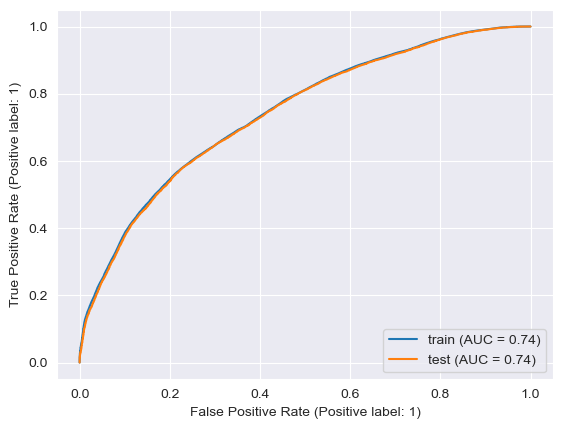

In [37]:

fig, ax = plt.subplots()
RocCurveDisplay.from_estimator(model, X_train, y_train, ax=ax, name='train')
RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax, name='test')

In [38]:
# importances = model.feature_importances_
# feature_names = ct.get_feature_names_out()
#
# # Extract column names from feature names
# column_names = []
# for feature_name in feature_names:
#     match = re.search('onehot__(.*?)_', feature_name)
#     if match:
#         column_names.append(match.group(1))
#     elif feature_name.startswith('remainder_'):
#         column_names.append(feature_name.replace('remainder__', ''))
#     else:
#         column_names.append(feature_name)
#
# # Create a DataFrame with column names and importances
# df_importances = pd.DataFrame({'column': column_names, 'importance': importances})
#
# # Aggregate importances by column
# df_importances = df_importances.groupby('column').agg({'importance': 'sum'}).reset_index()
#
# # Create a bar plot of feature importances
# plt.bar(x=df_importances['column'], height=df_importances['importance'])
# plt.xticks(rotation=90)
# plt.xlabel('Column name')
# plt.ylabel('Importance')
# plt.title('Feature importances from Random Fores model')
# plt.show()

In [39]:
# df_importances.to_csv('feature_importances.csv', index=False)

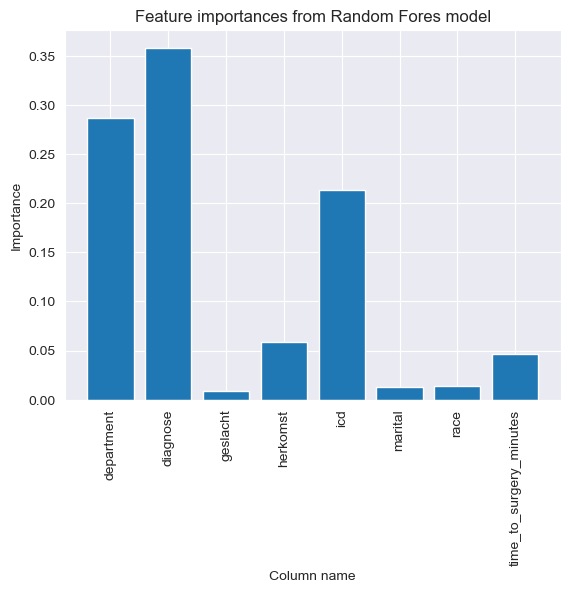

In [40]:
importances = model.named_steps['model'].feature_importances_
feature_names = model.named_steps['preprocessor'].get_feature_names_out()

# Extract column names from feature names
column_names = []
for feature_name in feature_names:
    match = re.search('onehot__(.*?)_', feature_name)
    if match:
        column_names.append(match.group(1))
    elif feature_name.startswith('remainder_'):
        column_names.append(feature_name.replace('remainder__', ''))
    else:
        column_names.append(feature_name)

# Create a DataFrame with column names and importances
df_importances = pd.DataFrame({'column': column_names, 'importance': importances})

# Aggregate importances by column
df_importances = df_importances.groupby('column').agg({'importance': 'sum'}).reset_index()

# Create a bar plot of feature importances
plt.bar(x=df_importances['column'], height=df_importances['importance'])
plt.xticks(rotation=90)
plt.xlabel('Column name')
plt.ylabel('Importance')
plt.title('Feature importances from Random Fores model')
plt.show()

## ROC train vs test.

In een ROC-curve vertegenwoordigt de x-as de false positive rate (FPR), wat de proportie is van negatieve gevallen die onjuist als positief worden geclassificeerd, terwijl de y-as de true positive rate (TPR) vertegenwoordigt, wat de proportie is van positieve gevallen die correct als positief worden geclassificeerd.

De ROC-curve laat de relatie zien tussen TPR en FPR voor verschillende waarden van de classificatiedrempel. De oppervlakte onder de ROC-curve (AUC) is een veelgebruikte maatstaf voor het evalueren van de prestaties van binaire classificatiemodellen. De AUC-waarde varieert van 0 tot 1, waarbij een hogere waarde betere prestaties van het classificatiemodel aangeeft.

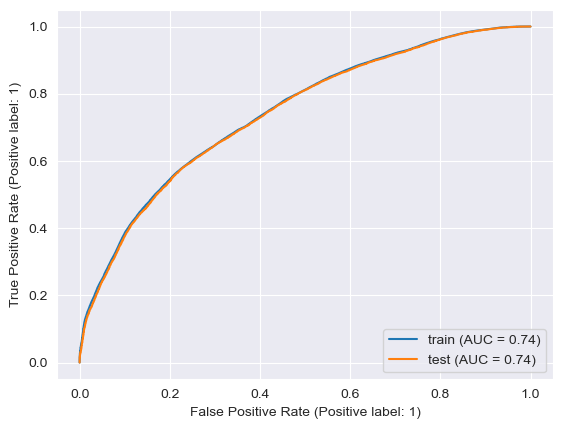

In [41]:
fig, ax = plt.subplots()
RocCurveDisplay.from_estimator(model, X_train, y_train, ax=ax, name='train')
RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax, name='test')

## Brier score en reliability diagram.

De Brier score wordt berekend als de gemiddelde kwadratische afstand tussen de werkelijke uitkomst (0 of 1) en de voorspelde kans (een getal tussen 0 en 1), over alle voorbeelden in de dataset. Het is dus een continue score, waarbij lagere waarden duiden op betere prestaties van het model.

Een reliability diagram, ook wel een calibration plot genoemd, is een grafische weergave van de kalibratie van een voorspellingsmodel voor een binair classificatieprobleem. Het toont de overeenstemming tussen de voorspelde kansen van het model en de daadwerkelijke frequenties van de positieve klasse.

In [42]:
prob_pos = model.predict_proba(X_test)[:, 1]
# Generate the reliability diagram
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)

In [43]:
brier_score = brier_score_loss(y_test, prob_pos)

print('Brier score:', brier_score) # 0 is best, 1 worst

Brier score: 0.211938493556407


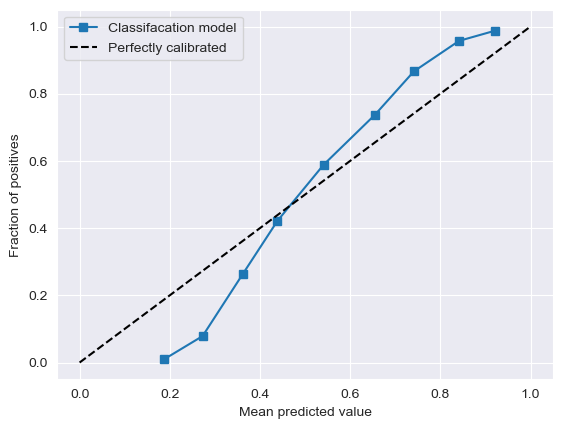

In [44]:
# Plot the reliability diagram
plt.plot(mean_predicted_value, fraction_of_positives, 's-', label='Classifacation model')
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted value')
plt.ylabel('Fraction of positives')
plt.legend()
plt.show()

## Confusion matrix.

Een confusion matrix is een tabel die wordt gebruikt om de prestaties van een voorspellingsmodel voor een binair classificatieprobleem te evalueren. Het toont het aantal voorspellingen dat juist en onjuist is geclassificeerd in termen van de werkelijke positieve en negatieve klassen.

De matrix heeft vier cellen: true positives (TP), false positives (FP), false negatives (FN) en true negatives (TN). True positives zijn de voorbeelden die correct als positief zijn geclassificeerd, terwijl false positives de voorbeelden zijn die foutief als positief zijn geclassificeerd. False negatives zijn de voorbeelden die foutief als negatief zijn geclassificeerd, en true negatives zijn de voorbeelden die correct als negatief zijn geclassificeerd.

In [45]:
y_pred = model.predict(X_test)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

Text(0.5, 427.9555555555555, 'Predicted label')

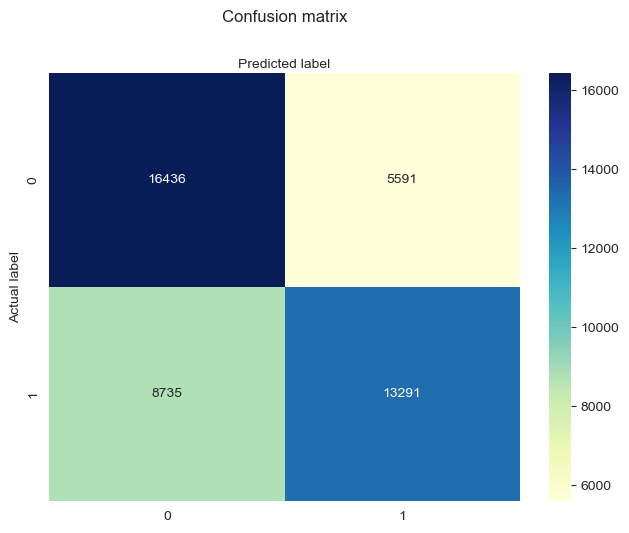

In [46]:
class_names=[0,1] # name  of classes 

fig, ax = plt.subplots() 

tick_marks = np.arange(len(class_names)) 

plt.xticks(tick_marks, class_names) 

plt.yticks(tick_marks, class_names) 

# create heatmap 

sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g') 

ax.xaxis.set_label_position("top") 

plt.tight_layout() 

plt.title('Confusion matrix', y=1.1) 

plt.ylabel('Actual label') 

plt.xlabel('Predicted label')

## Voeg predicted value en proba toe.

Aan de DF wordt een kolom gemaakt waarin de voorspelde waarde staat en de zekerheid van het model over die voorspelling.

In [47]:
# yhat = model.predict(X) # predict classes for the dataset
# yhat_proba = model.predict_proba(X) # predict probabilities for the dataset
#
# df['predicted_class'] = yhat
# df['predicted_prob'] = [y[max_idx] * 100 for y, max_idx in zip(yhat_proba, yhat)]
#
# # update the existing columns with the new values
# df.loc[:, 'predicted_class'] = yhat
# df.loc[:, 'predicted_prob'] = [y[max_idx] * 100 for y, max_idx in zip(yhat_proba, yhat)]

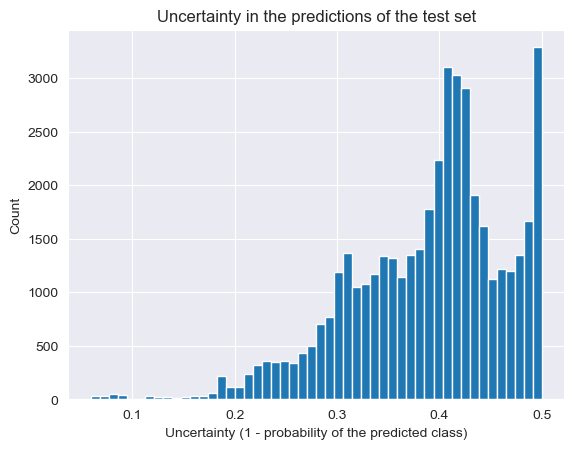

In [48]:
# lets calculate the uncertainty of the test set
yhat_proba_test = model.predict_proba(X_test) # predict probabilities for the test set
yhat_proba_test_uncertainty = [1 - y.max() for y in yhat_proba_test] # uncertainty is 1 - probability of the predicted
#plot the uncertainty
plt.hist(yhat_proba_test_uncertainty, bins=50)
plt.xlabel('Uncertainty (1 - probability of the predicted class)')
plt.ylabel('Count')
plt.title('Uncertainty in the predictions of the test set')
plt.show()




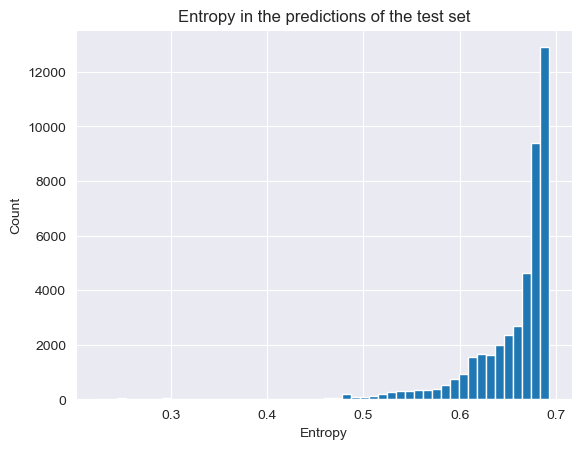

[0.6825331608129446, 0.6729139910262139, 0.6902076023571376, 0.6422827029429008, 0.6906042026488015, 0.6720707595762341, 0.6925597863181601, 0.5970809546988961, 0.6922675680599322, 0.6928580395612765, 0.6929062150528703, 0.5273275541083843, 0.6929501791901258, 0.6719395654187739, 0.6177002199815302, 0.6433954762804193, 0.6375389586473528, 0.6227952887744852, 0.629008213269566, 0.6790847977399059, 0.6843404966290255, 0.4556426849099401, 0.6654961305299061, 0.6917287380691225, 0.6842675376176979, 0.6142176270273864, 0.6735907456494818, 0.6183980539183804, 0.651043365517246, 0.6898417977286194, 0.633839570901108, 0.6823960222760379, 0.6539352365198459, 0.6844944480198307, 0.614845179503636, 0.2395848566268482, 0.6856602682536685, 0.646319488781352, 0.6307910062190834, 0.6406972381560094, 0.6292909055168816, 0.6919598417143488, 0.5270076159706772, 0.6764437422392164, 0.677429994807887, 0.692209725591209, 0.6814570247712204, 0.5386265893967359, 0.6926200915832486, 0.6777767341936736, 0.6930

In [49]:
# lets calulate the entropy values for the test set
from scipy.stats import entropy
yhat_proba_test_entropy = [entropy(y) for y in yhat_proba_test]
#plot the entropy
plt.hist(yhat_proba_test_entropy, bins=50)
plt.xlabel('Entropy')
plt.ylabel('Count')
plt.title('Entropy in the predictions of the test set')
plt.show()

print(yhat_proba_test_entropy)

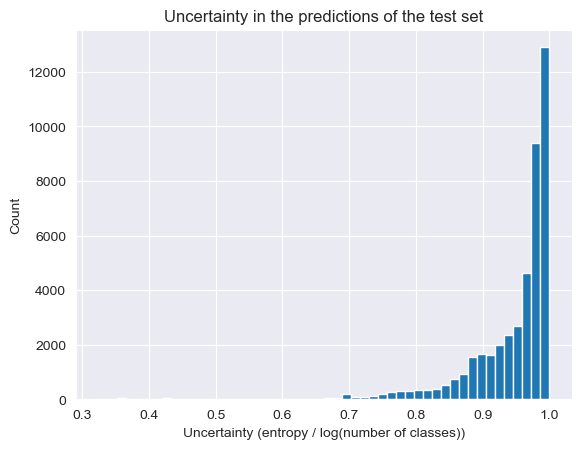

In [50]:
# lets convert the entropy values to uncertainty values in percentages
n_classes = 2
yhat_proba_test_uncertainty = [y / np.log(n_classes) for y in yhat_proba_test_entropy]

#plot de onzekerheid
plt.hist(yhat_proba_test_uncertainty, bins=50)
plt.xlabel('Uncertainty (entropy / log(number of classes))')
plt.ylabel('Count')
plt.title('Uncertainty in the predictions of the test set')
plt.show()


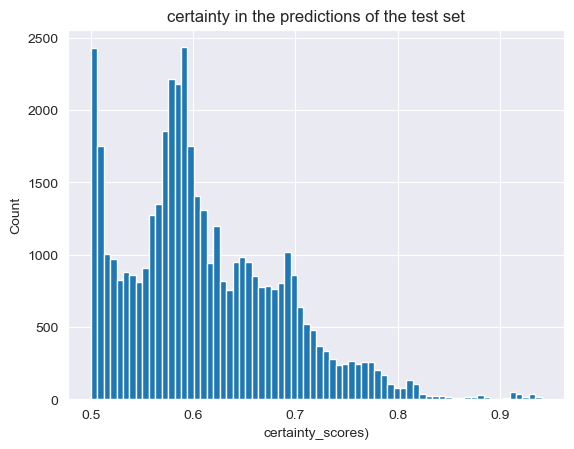

In [51]:
# Stel dat 'model' je getrainde model is en 'X_test' je test data
probs = model.predict_proba(X_test)

# Zekerheidsscore voor elke voorspelling is de maximale waarschijnlijkheid
certainty_scores = probs.max(axis=1)

#plot de onzekerheid
plt.hist(certainty_scores, bins=70)
plt.xlabel('certainty_scores)')
plt.ylabel('Count')
plt.title('certainty in the predictions of the test set')
plt.show()

In [52]:
X_test.columns

Index(['geslacht', 'herkomst', 'marital_status', 'race', 'diagnose',
       'icd_version', 'department', 'time_to_surgery_minutes'],
      dtype='object')

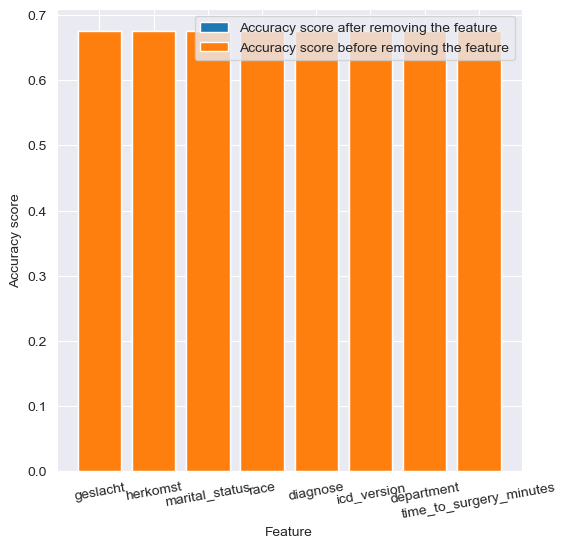

In [53]:
# Prepare test data with feature removed and save the results of accuracy scores in a list and plot it
scores_list = [] #will contain a tuples of (feature, accuracy scoreafter removing the feature, accuracy score before removing the feature) for each feature
for i in X_test.columns:
    X_test_removed = X_test.copy()
    X_test_removed[i].replace( np.nan, inplace=True)

    # Make predictions with both original and modified test data
    y_pred_original = model.predict(X_test)
    y_pred_removed = model.predict(X_test_removed)

    # Calculate and compare accuracy scores
    accuracy_original = accuracy_score(y_test, y_pred_original)
    accuracy_removed = accuracy_score(y_test, y_pred_removed)

    # Save the results in a list
    scores_list.append((i, accuracy_removed, accuracy_original))

# Sort the list by accuracy score after removing the feature
scores_list.sort(key=lambda x: x[1], reverse=True)
#lets plot the results in a bar chart of both accuracy scores before and after removing the feature for each feature
plt.figure(figsize=(6, 6))

plt.bar([x[0] for x in scores_list], [x[1] for x in scores_list], label='Accuracy score after removing the feature')
plt.bar([x[0] for x in scores_list], [x[2] for x in scores_list], label='Accuracy score before removing the feature')
plt.xticks(rotation=10)
plt.xlabel('Feature')
plt.ylabel('Accuracy score')
plt.legend()
plt.show()



In [54]:
print(scores_list)

[('geslacht', 0.6748008081174949, 0.6748008081174949), ('herkomst', 0.6748008081174949, 0.6748008081174949), ('marital_status', 0.6748008081174949, 0.6748008081174949), ('race', 0.6748008081174949, 0.6748008081174949), ('diagnose', 0.6748008081174949, 0.6748008081174949), ('icd_version', 0.6748008081174949, 0.6748008081174949), ('department', 0.6748008081174949, 0.6748008081174949), ('time_to_surgery_minutes', 0.6748008081174949, 0.6748008081174949)]


Removed features: ('geslacht', 'herkomst')
Accuracy with original features: 0.6748008081174949
Accuracy with features removed: 0.6600912537171135


Removed features: ('geslacht', 'marital_status')
Accuracy with original features: 0.6748008081174949
Accuracy with features removed: 0.6733253126915306


Removed features: ('geslacht', 'race')
Accuracy with original features: 0.6748008081174949
Accuracy with features removed: 0.6729848137470774


Removed features: ('geslacht', 'diagnose')
Accuracy with original features: 0.6748008081174949
Accuracy with features removed: 0.6368919256350305


Removed features: ('geslacht', 'icd_version')
Accuracy with original features: 0.6748008081174949
Accuracy with features removed: 0.629968447097814


Removed features: ('geslacht', 'department')
Accuracy with original features: 0.6748008081174949
Accuracy with features removed: 0.6372324245794838


Removed features: ('geslacht', 'time_to_surgery_minutes')
Accuracy with original features: 0.6748008081174

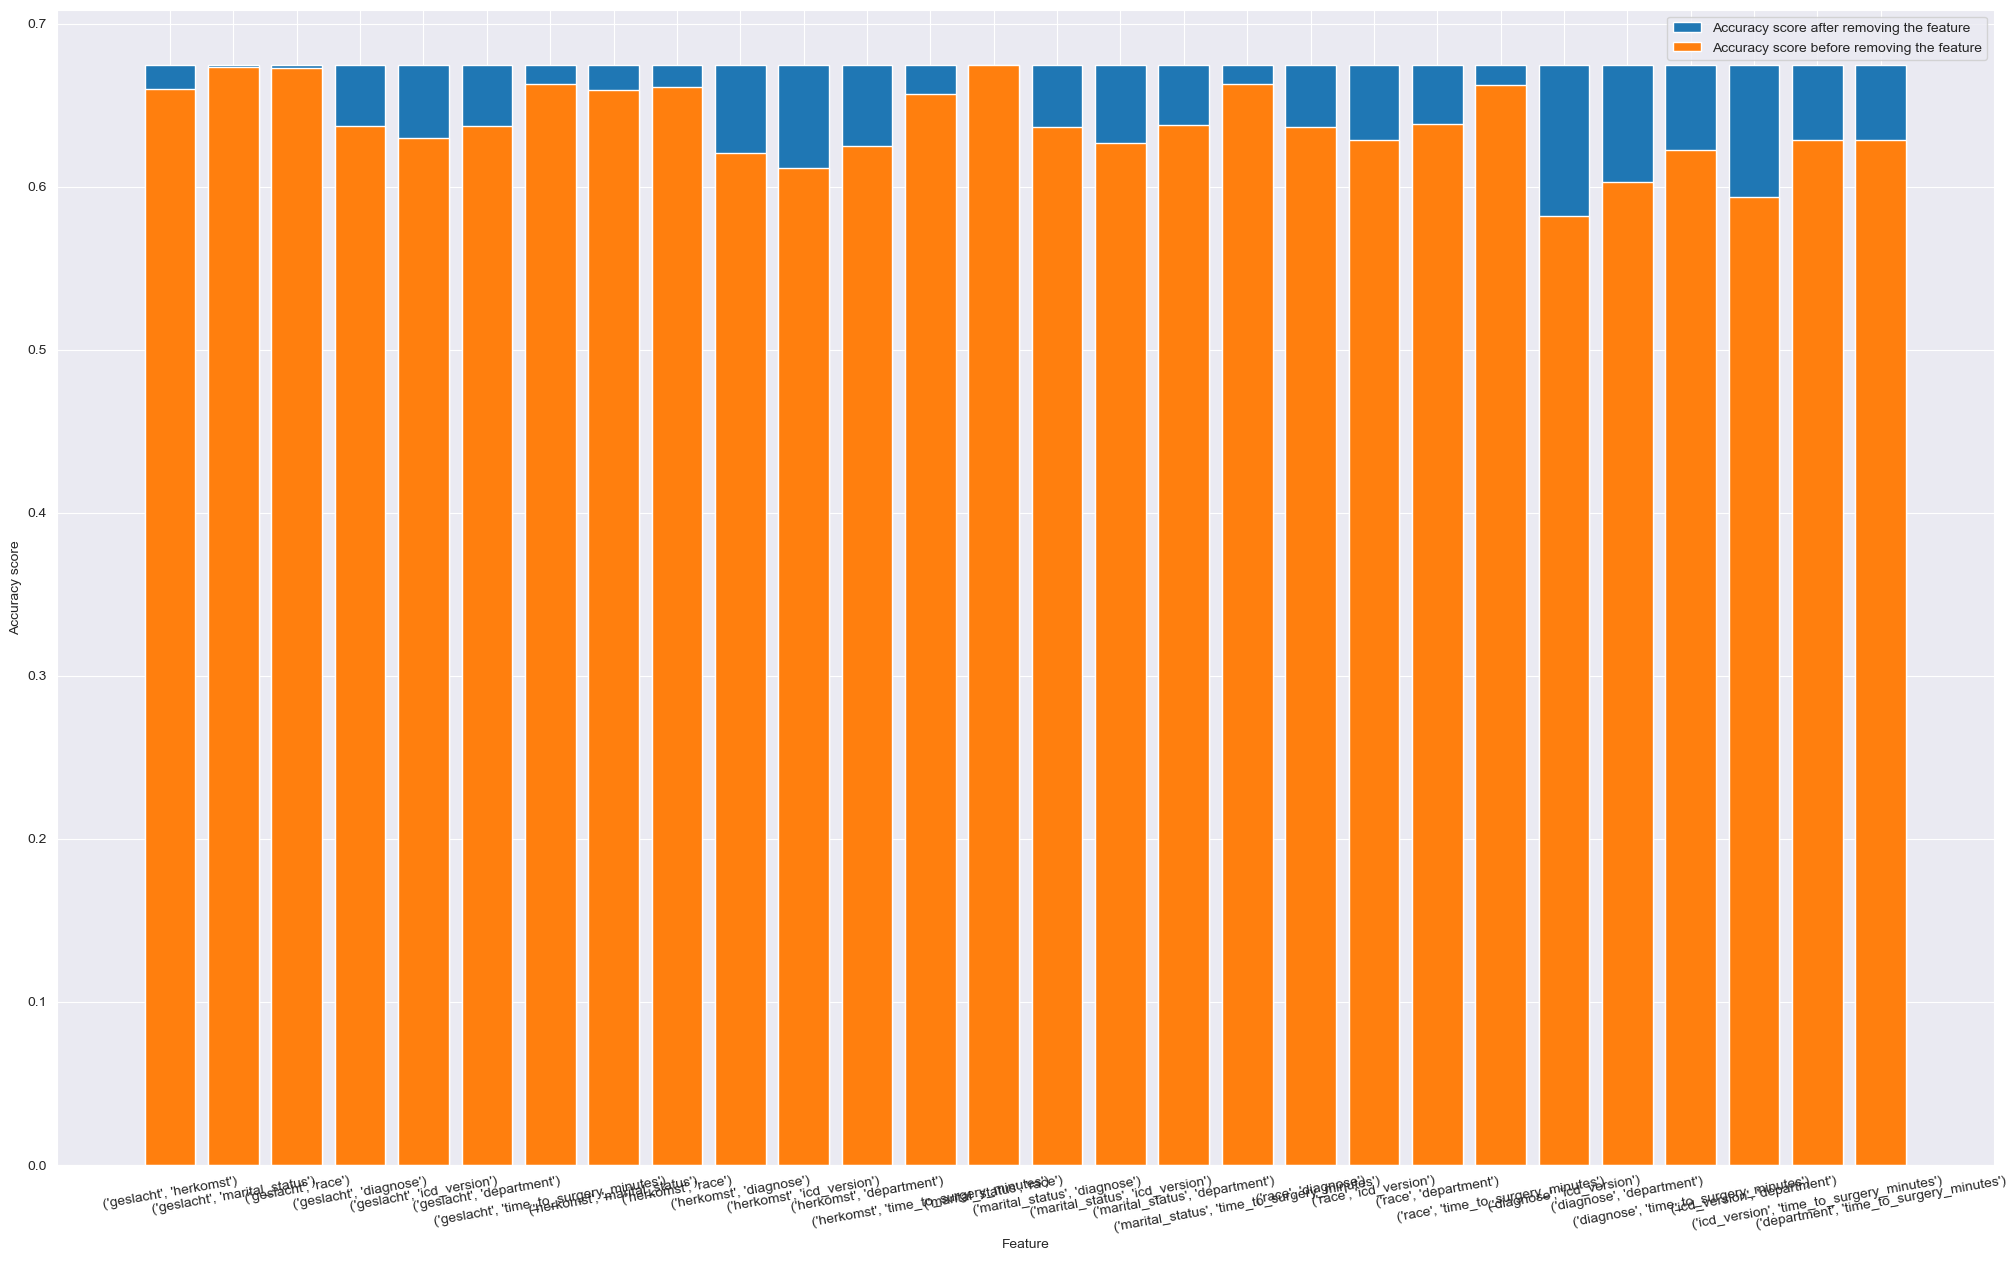

In [55]:
from itertools import combinations
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

# Assuming X_test, y_test, and model are defined

# List of all features
all_features = X_test.columns.tolist()

# Number of features to remove at a time
n_remove = 2

# Prepare a list to store the results
results = []

# Loop over all combinations of n_remove features
for features in combinations(all_features, n_remove):
    # Prepare test data with features removed
    X_test_removed = X_test.copy()
    X_test_removed[list(features)] = None  # replace with np.nan, which will be imputed later

    # Make predictions with both original and modified test data
    y_pred_original = model.predict(X_test)
    y_pred_removed = model.predict(X_test_removed)

    # Calculate and compare accuracy scores
    accuracy_original = accuracy_score(y_test, y_pred_original)
    accuracy_removed = accuracy_score(y_test, y_pred_removed)

    # Store the results
    results.append((features, accuracy_original, accuracy_removed))

# Print the results
for features, accuracy_original, accuracy_removed in results:
    print(f"Removed features: {features}")
    print(f"Accuracy with original features: {accuracy_original}")
    print(f"Accuracy with features removed: {accuracy_removed}")
    print("\n")

#lets plot the results in a bar chart of both accuracy scores before and after removing the feature for each feature
#lets plot the results in a bar chart of both accuracy scores before and after removing the feature for each feature
plt.figure(figsize=(25, 15))
plt.bar([str(x[0]) for x in results], [x[1] for x in results], label='Accuracy score after removing the feature')
plt.bar([str(x[0]) for x in results], [x[2] for x in results], label='Accuracy score before removing the feature')
plt.xticks(rotation=10)
plt.xlabel('Feature')
plt.ylabel('Accuracy score')
plt.legend()
plt.show()


In [56]:
# For each feature
# for feature in X_test.columns:
#     if feature in categorical_cols:
#         # If the feature is categorical, change the category
#         for category in X_test[feature].unique():
#             if category != test_point.iloc[0][feature]:
#                 test_point.iloc[0][feature] = category
#                 if model.predict(test_point) != initial_prediction:
#                     print(f"Changing {feature} to {category} changed the prediction")
#                     break
#     else:
#         # If the feature is numerical, start changing the feature value until the prediction changes
#         original_value = test_point.iloc[0][feature]
#         test_point.iloc[0][feature] = original_value + step_size
#         while model.predict(test_point) == initial_prediction:
#             test_point.iloc[0][feature] += step_size
#         print(f"Changing {feature} by {test_point.iloc[0][feature] - original_value} changed the prediction")


In [57]:
import pandas as pd
import numpy as np
import concurrent.futures

# Make a copy of the first test point
test_point = X_test.iloc[[0]].copy()

# Calculate the initial prediction for the test point
initial_prediction = model.predict(test_point)

# Define a small step size for changing the feature value
step_size = 0.001

# Define a maximum number of iterations to avoid an infinite loop
max_iterations = 1000

def change_feature_and_predict(feature):
    # Copy the test point to avoid race conditions
    test_point_copy = test_point.copy()

    # Start your modification
    if feature in categorical_cols:
        # If the feature is categorical, change the category
        for category in X_test[feature].unique():
            if category != test_point_copy.iloc[0][feature]:
                test_point_copy.iloc[0, test_point_copy.columns.get_loc(feature)] = category
                if model.predict(test_point_copy) != initial_prediction:
                    return f"Changing {feature} to {category} changed the prediction"
    else:
        # If the feature is numerical, start changing the feature value until the prediction changes
        original_value = test_point_copy.iloc[0][feature]
        test_point_copy.iloc[0, test_point_copy.columns.get_loc(feature)] = original_value + step_size
        iterations = 0
        while model.predict(test_point_copy) == initial_prediction and iterations < max_iterations:
            test_point_copy.iloc[0, test_point_copy.columns.get_loc(feature)] += step_size
            iterations += 1
        if iterations < max_iterations:
            return f"Changing {feature} by {test_point_copy.iloc[0][feature] - original_value} changed the prediction"

    # If no change affected the prediction
    return f"No change in {feature} affected the prediction"

# Create a ThreadPoolExecutor
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Use a list comprehension to create a list of Future objects
    futures = [executor.submit(change_feature_and_predict, feature) for feature in X_test.columns]

    # As the futures complete, print their results
    for future in concurrent.futures.as_completed(futures):
        print(future.result())


No change in geslacht affected the prediction
Changing diagnose to 042 changed the prediction
No change in icd_version affected the prediction
No change in herkomst affected the prediction
No change in marital_status affected the prediction
Changing department to GYN changed the prediction
No change in race affected the prediction
No change in time_to_surgery_minutes affected the prediction


In [58]:
def change_feature_and_predict(feature):
    # Copy the test point to avoid race conditions
    test_point_copy = test_point.copy()

    # Start your modification
    if feature in categorical_cols:
        # If the feature is categorical, change the category
        for category in X_test[feature].unique():
            if category != test_point_copy.iloc[0][feature]:
                test_point_copy.iloc[0, test_point_copy.columns.get_loc(feature)] = category
                if model.predict(test_point_copy) != initial_prediction:
                    return (feature, category)  # return tuple for categorical feature change
    else:
        # If the feature is numerical, start changing the feature value until the prediction changes
        original_value = test_point_copy.iloc[0][feature]
        test_point_copy.iloc[0, test_point_copy.columns.get_loc(feature)] = original_value + step_size
        iterations = 0
        while model.predict(test_point_copy) == initial_prediction and iterations < max_iterations:
            test_point_copy.iloc[0, test_point_copy.columns.get_loc(feature)] += step_size
            iterations += 1
        if iterations < max_iterations:
            return (feature, test_point_copy.iloc[0][feature] - original_value)  # return tuple for numerical feature change

    # If no change affected the prediction
    return (feature, None)  # return tuple with None if no change affected prediction

In [59]:
# As the futures complete, gather their results into a list
results = [future.result() for future in concurrent.futures.as_completed(futures)]


In [60]:
results

['No change in geslacht affected the prediction',
 'No change in race affected the prediction',
 'No change in herkomst affected the prediction',
 'No change in icd_version affected the prediction',
 'No change in marital_status affected the prediction',
 'Changing diagnose to 042 changed the prediction',
 'Changing department to GYN changed the prediction',
 'No change in time_to_surgery_minutes affected the prediction']